# Lasso model

Lasso model had features selected by iteratively looking at VIF and coefficients of different features. Then testing which features were best to remove to maximize CV score and minimize VIF for each feature. Final lasso model had the best RMSE of all models with a 53 RMSE.

In [1]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import helper

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import matplotlib.style as style
plt.style.use("markerr.mplstyle")

#### Loading and processing data to put into model. And Construct model.

In [2]:
# load data
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# Merge and lag data to be ready to forecast a year in the future
merged_df = helper.zri_data_pipeline(zri, texas_data, acs_data)

# Split dataframe into train, test, and forecast,
train, test, forecast = helper.train_test_forecast_split(
    merged_df,
    train_date = datetime.datetime(2020,7,2), 
    forecast_date = datetime.datetime(2021,7,2)
)

# define features to be put into the model and target variable.

X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',    
    'tx_net_approve_12_month_shift'
    ]
y_val = 'zori_ssa'

# Shrink data to features to be put into the model
# and scale data to prepare it to be put into the model
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test all
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)

# construct model
clf = helper.lasso_gridCV_fit(X, y)

Performing Grid Search with alphas of: [0.1, 0.2, 0.3, 0.6, 1]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha 0.1


####  Getting test scores. RMSE and R^2

In [3]:
y_pred_test = clf.predict(X_test)

test.loc[:,'pred'] = y_pred_test
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_pred_test

rms = mean_squared_error(y_test, y_pred_test, squared=False)
rms


53.56478327318194

In [4]:
r2_score(y_test, y_pred_test)


0.9553451892401778

####  Feeding forecast values into model

In [5]:
y_pred_fore = clf.predict(X_forecast)
forecast.loc[:,'pred'] = y_pred_fore


#### Construct timeline of zori and what prediciton status they are.

In [6]:
# put actual data into correct format
zori_pred_act = zri[['Time','zip_code','zori_ssa']].dropna(subset=['zori_ssa'])
zori_pred_act['model_code'] = 'actual_values'
# put train into correct format
zori_pred_train = test[['Time','zip_code','pred']]
zori_pred_train.columns = ['Time','zip_code','zori_ssa']
zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
# put forecast into correct format
zori_pred_fore = forecast[['Time','zip_code','pred']]
zori_pred_fore.columns = ['Time','zip_code','zori_ssa']
zori_pred_fore['model_code'] = 'lasso_base'
# concat them together
zori_pred = pd.concat([zori_pred_act, zori_pred_train, 
                       zori_pred_fore]).reset_index(drop=True)

# zori_pred.to_csv('zori_pred_lasso_base.csv')

<ipython-input-6-8466dcc37687>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
<ipython-input-6-8466dcc37687>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_fore['model_code'] = 'lasso_base'


<ipython-input-9-bb082b77cb92>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])


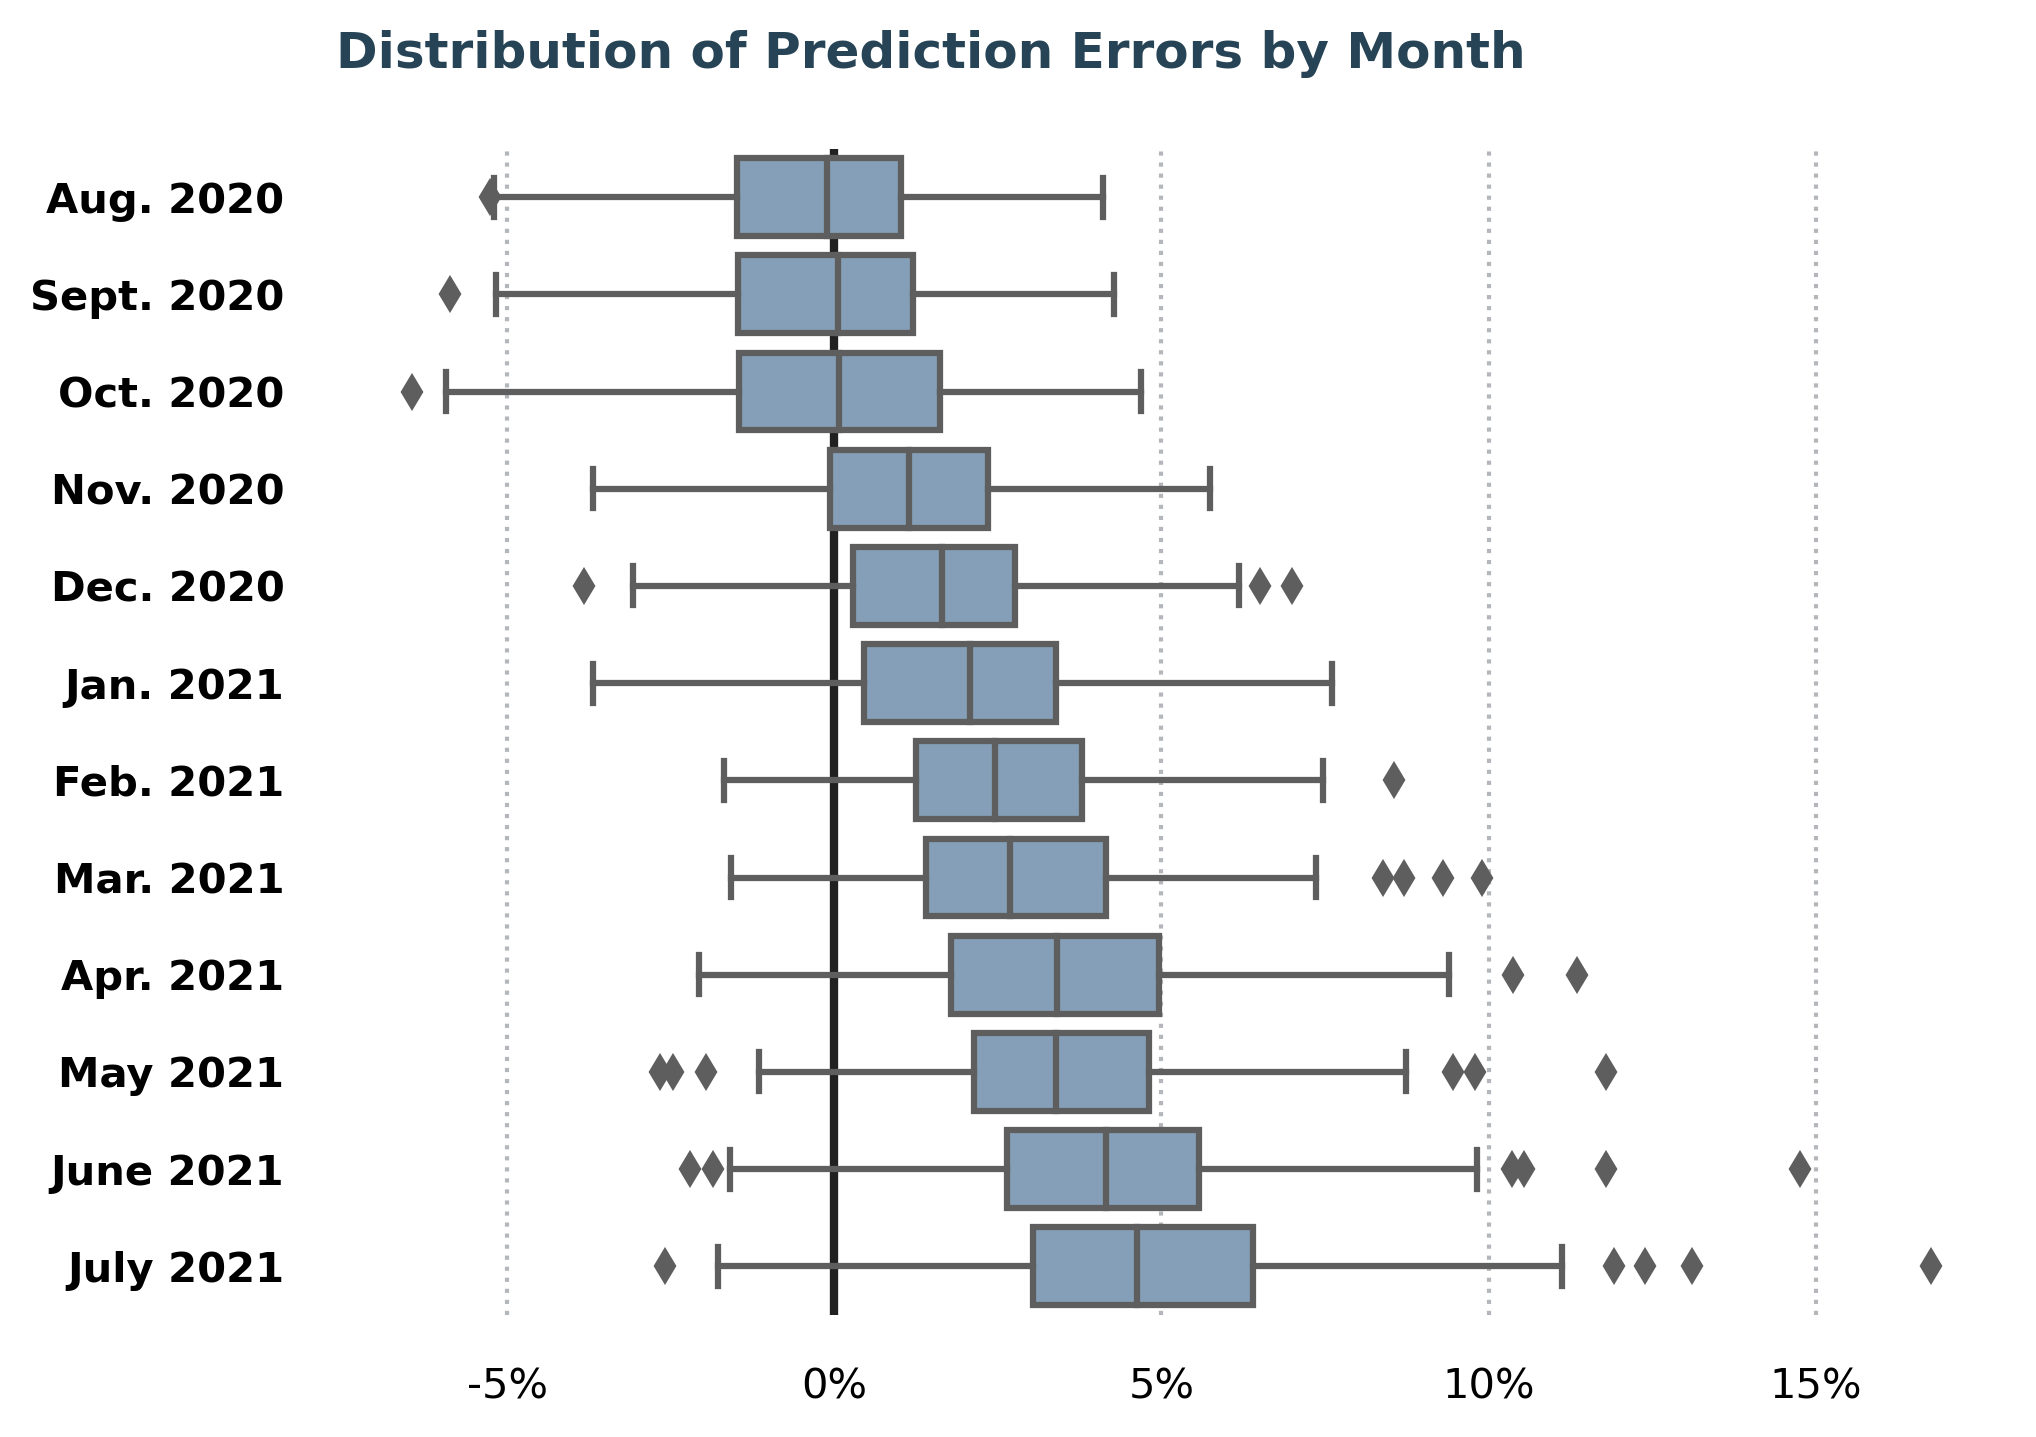

In [9]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']

graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
colors2 = ['#274456','#7BA0C0']
fig, ax = plt.subplots()
g = sns.boxplot(data = graph_df, y = 'Time',x = 'pred_difference_per', 
                color = colors2[1], ax = ax)
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')
# make the highlighted features bold. should be the same side with the visible spine
plt.yticks(fontweight='bold')

# set labels
g.set_yticklabels(labels = [
    'Aug. 2020', 'Sept. 2020', 'Oct. 2020', 'Nov. 2020',
    'Dec. 2020', 'Jan. 2021', 'Feb. 2021', 'Mar. 2021', 'Apr. 2021',
    'May 2021', 'June 2021', 'July 2021'
])



# set title
g.set(xlabel='', ylabel='',
      title='Distribution of Prediction Errors by Month\n')

# adding a vertical line at 0 percent growth
blacks = ['#212121']
plt.axvline(0, color = blacks[0], zorder = .7, linewidth = 2)

g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')



plt.show()